# Discovering Object-Centric Causal Nets with Edge-Coarse-Graining

This notebook demonstrates how the discovery and visualization of an Object-centric Casual nets is done as presented in the paper *Discovering Object-Centric Causal Nets with Edge-Coarse-Graining in Process Mining*.

Let us start! First, we import the necessary libraries and packages.

In [2]:
import pm4py

from discover_occnets import *
from view_occnets_jupyter import *

Second, we open the OCEL 2.0 log file and import it.

In [3]:
file_path = './order-management.sqlite'

In [4]:
ocel, ot_activities, event_to_obj, obj_to_obj = import_log(file_path)

## Discovering Object-centric Causal Nets

The approach introduced in the paper uses the discovery of Causal nets for each object type (OT) in the log and then merges them into an object-centric Causal nets model. This example is based on an order management process. We begin by viewing the complete model, including all object types encountered in the business process. However, first let us take a glance at the object types and their related activities.

In [11]:
ot_activities, subgraphs = subgraphs_dict(file_path, dependency_threshold=0.99)
for k,v in ot_activities.items():
    print(k,v)

customers {'place order', 'confirm order'}
employees {'create package', 'item out of stock', 'reorder item', 'confirm order', 'pick item', 'send package', 'failed delivery', 'package delivered'}
items {'create package', 'item out of stock', 'pay order', 'place order', 'reorder item', 'confirm order', 'pick item', 'send package', 'failed delivery', 'package delivered', 'payment reminder'}
orders {'place order', 'pay order', 'confirm order', 'payment reminder'}
products {'create package', 'item out of stock', 'pay order', 'place order', 'reorder item', 'confirm order', 'pick item', 'send package', 'failed delivery', 'package delivered', 'payment reminder'}
packages {'create package', 'package delivered', 'send package', 'failed delivery'}


<br>
Note that activities {'package delivered', 'send package', 'create package', 'failed delivery'} are common to object types *items* and *packages*. This would result in more than one edge connecting two activities, one for each object type. To solve this, the edges of different object types representing single bindings that connect the same activities are merged using the **edge-coarse-graining** technique to reduce cluttering. The frequency and dependency measures are shown in different colors assigned to each object type, for clarity. The final step is to generate the model and the legend for visualization. 

<br>
Next, we visualize the model for all the object types.

In [25]:
OCCN_model = all_ot_visualization(ot_activities, subgraphs)

<view_occnets_jupyter.all_ot_visualization.<locals>.InteractiveSVG at 0x3159b5090>

## Visualizing selected object types in the OCCN model

Although it is possible to visualize all object types in the same model, it can become cluttered and hinder the analysis. In object-centric process mining, users often want to focus on some object types to analyze relationships between them. Thus, it is possible to select any number of object types to be visualized in the model using a profile, which is the list of object types to be included in the visualization. If not defined, the model will include all object types encountered in the OCEL file. In our case, the profile is ['orders','items','packages']. The model is graciously generated with the corresponding legend and randomly assigned colors for each object type:

In [40]:
OCCN_model = all_ot_visualization(ot_activities, subgraphs, profile=['orders', 'items', 'packages'])

<view_occnets_jupyter.all_ot_visualization.<locals>.InteractiveSVG at 0x3158f0dd0>

## Increasing Clarity through Different Binding Shapes

In addition, all OCCN models show the **input bindings and output bindings in different shapes** to improve the model readability. In this example, the activity *create package* has single and compound input bindings in blue for the OT 'items', both represented with a diamond shape. In contrast, the output bindings of the activities *pay order* and *pick item* are represented with a circle. If the model depicts many OT or all of them, there is a high load of information. However, the different binding shapes increase clarity. 


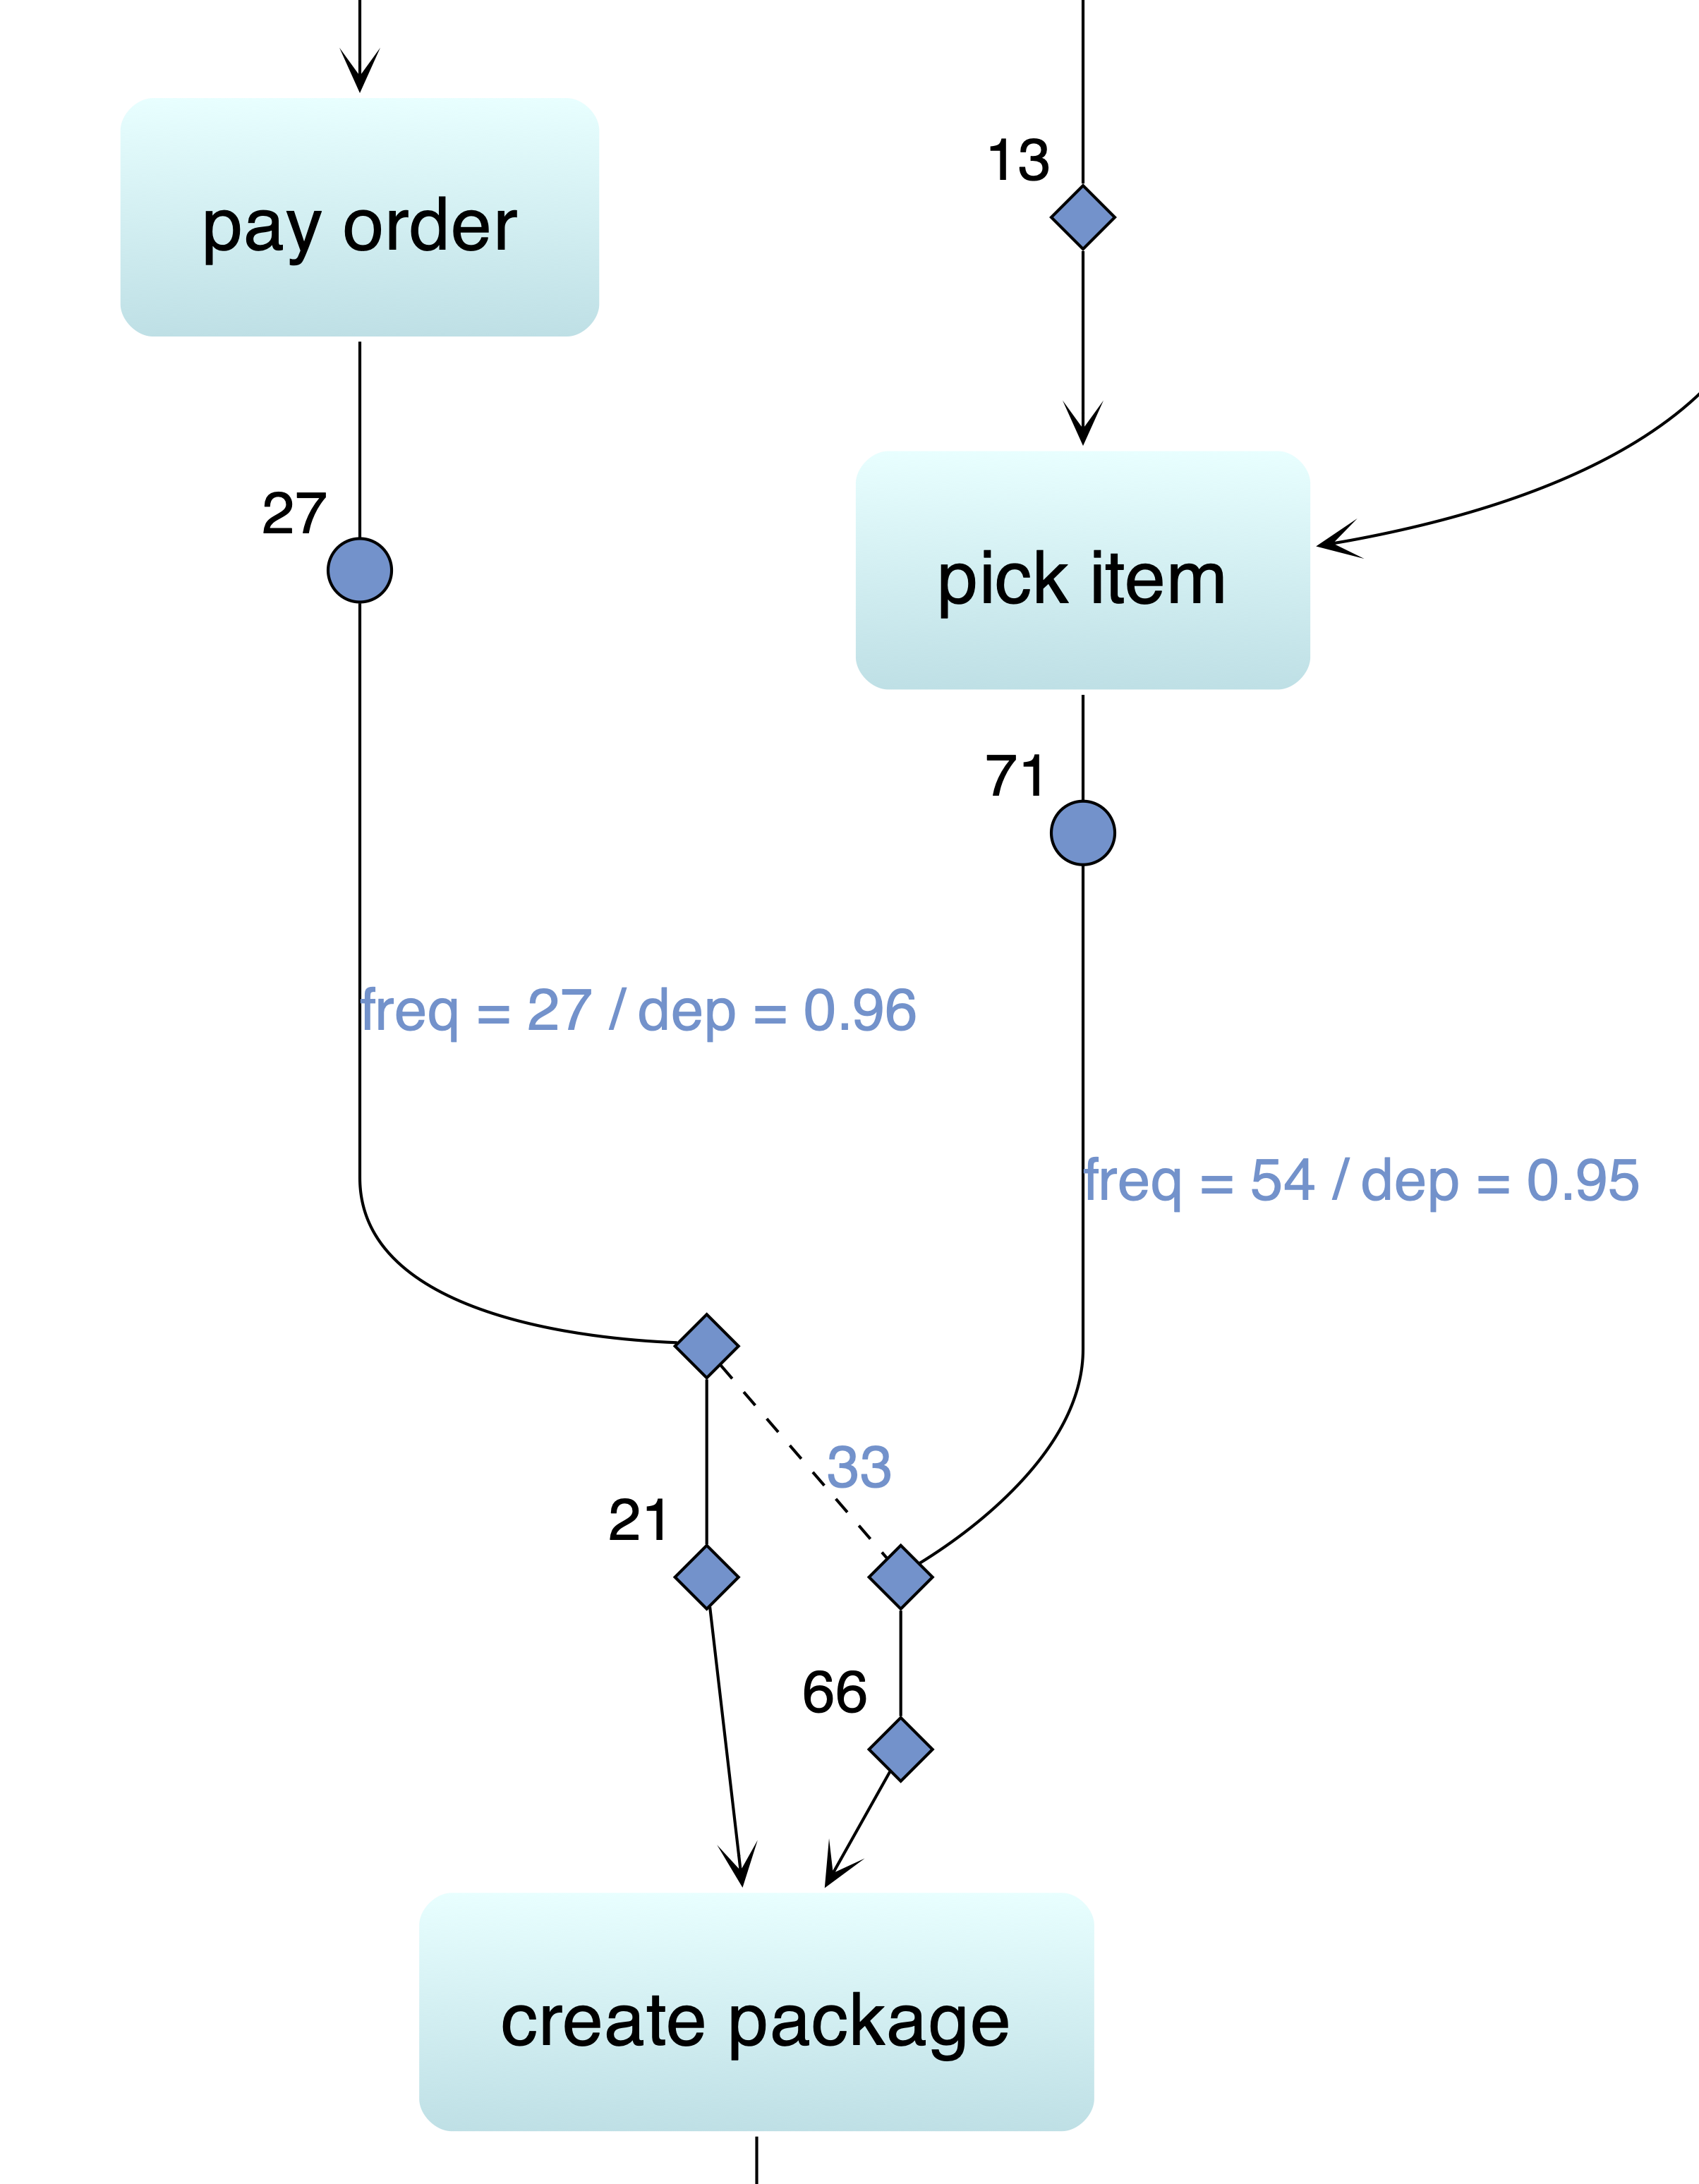

## Providing Additional Information in Tooltips

Simplicity is a key feature in object-centric process mining because models tend to present a high load of information. To provide clarity and harness information in the model, we use tooltips. Hovering the mouse over any activity shows a tooltip with statistics for each object type involved in the activity:

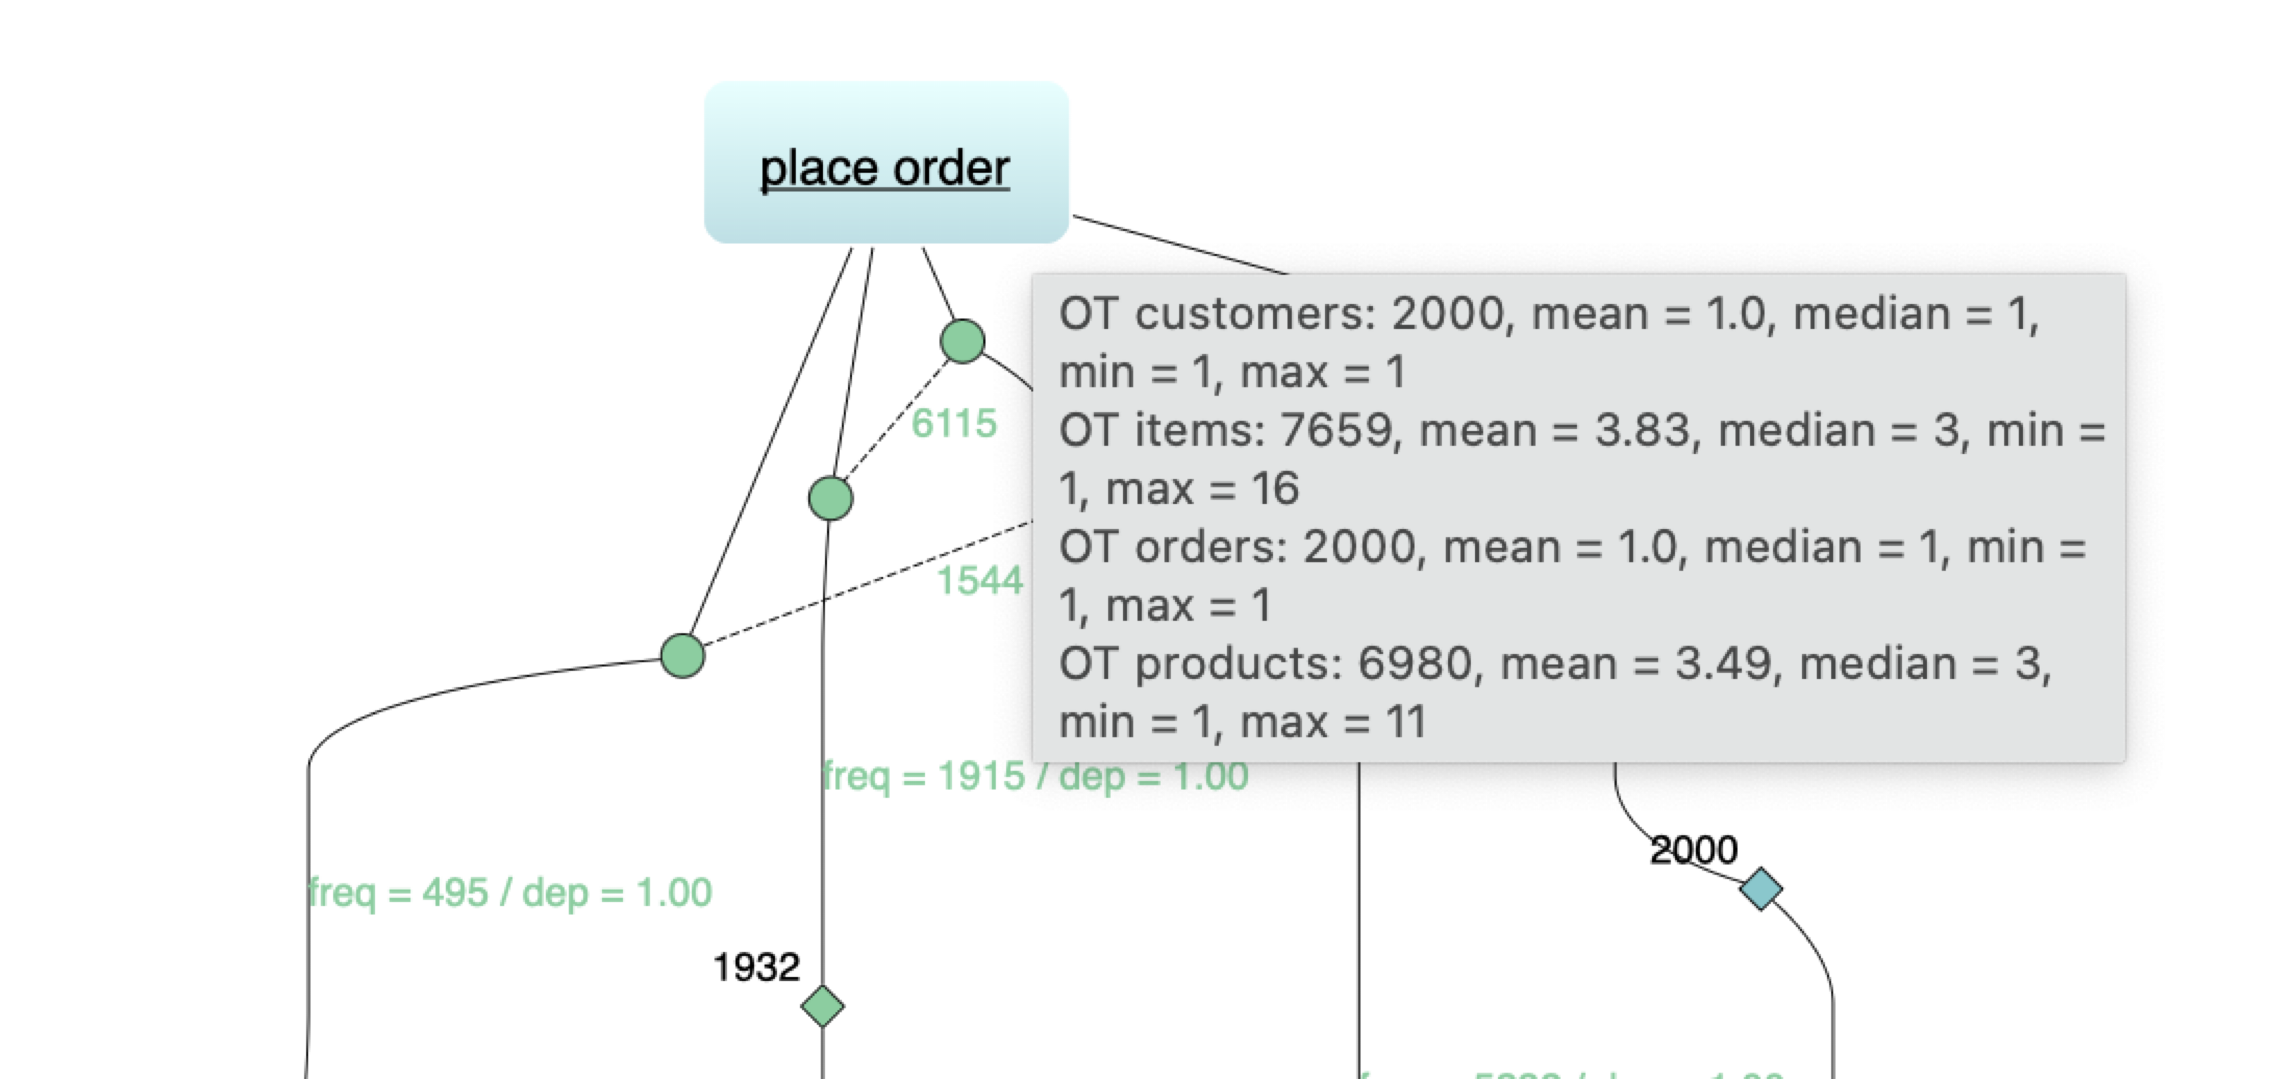

<br>
<br>
Now, we illustrate how Causal nets for each object type are discovered. Here, we choose the object type 'items'. These are the activities related to this object type.

In [14]:
print(ot_activities['items'])

{'create package', 'item out of stock', 'pay order', 'place order', 'reorder item', 'confirm order', 'pick item', 'send package', 'failed delivery', 'package delivered', 'payment reminder'}


First, we flatten and read the log. This allows us to have all activities related to the object type identified by the 'item' object ID and discover their traces, which is the sequence of activities for each object in the log.

In [15]:
ocel, ot_activities, event_to_obj, obj_to_obj = import_log(file_path)
flt = flatten_log(ocel, ot_activities)
flt_items = flt['items']
logs = read_log(flt)
logs_items = logs['items']
all_traces = traces(flt)
ot_traces = all_traces['items']

Let us see how the trace for item 'i-880001' looks like.

In [16]:
print(ot_traces['i-880001'])

['place order', 'pick item', 'confirm order', 'pay order', 'create package', 'send package', 'package delivered']


It shows all activities realized for item 'i-880001' in the order in which they happened, according to activity timestamps in the log. Next, we want to count some frequencies. As shown in the model, each activity has its corresponding total count. Also, the frequency one activity is followed by another activity is counted because it allows us to calculate the dependency measure between them. In addition, we discover the start and end activities for the object type 'items'.

In [17]:
act_total = activity_total(logs_items)
activities = activity_frequencies(logs_items)
or_start = original_start(act_total, activities)
or_end = original_end(act_total, activities)
freq = frequencies(activities)

Let us check how the frequency matrix for object type 'items' looks like.

In [18]:
print()
print('FREQUENCY MATRIX')
print()
print(freq)


FREQUENCY MATRIX

                   pick item  confirm order  item out of stock  place order  \
place order             35.0          118.0                6.0          0.0   
pick item                0.0           34.0                0.0          0.0   
confirm order           85.0            0.0               20.0          0.0   
pay order                8.0            0.0                0.0          0.0   
create package           1.0            0.0                0.0          0.0   
reorder item             9.0            1.0                0.0          0.0   
send package             0.0            1.0                0.0          0.0   
item out of stock        0.0            5.0                0.0          0.0   
package delivered        0.0            0.0                0.0          0.0   
payment reminder         0.0            0.0                0.0          0.0   
failed delivery          0.0            0.0                0.0          0.0   

                   payment remin

Now, we can proceed to calculate the dependencies between activities. If only frequencies were considered, noise in the log could influence it, causing underfitting and admitting more behavior than it should in the model. However, the dependency measures prevent this from happening and are the fundamental variables on which Causal nets rely. We use three formulas to calculate the dependency measures. The first one relates two activities to one another; the second one relates one activity to itself (loops); and the third one relates two non-consecutive activities and helps determine if there is a long-distance causal relation between them. Let us see the dependency matrix for the object type 'items'.

In [19]:
dep = dependency_matrix(freq)
dep_dict = dependency_dict(dep)
long = long_distance_dependency(act_total, ot_traces, or_start, or_end)
print()
print('DEPENDENCY MATRIX')
print()
print(dep)


DEPENDENCY MATRIX

                  pick item confirm order item out of stock place order  \
place order        0.972222      0.991597          0.857143         0.0   
pick item               0.0        -0.425               0.0   -0.972222   
confirm order         0.425           0.0          0.576923   -0.991597   
pay order         -0.484848     -0.952381         -0.666667         0.0   
create package    -0.946429     -0.947368               0.0         0.0   
reorder item            0.9          -0.5         -0.947368         0.0   
send package           -0.5           0.5               0.0         0.0   
item out of stock       0.0     -0.576923               0.0   -0.857143   
package delivered       0.0           0.0               0.0         0.0   
payment reminder       -0.5           0.0               0.0         0.0   
failed delivery         0.0           0.0               0.0         0.0   

                  payment reminder create package pay order send package  \
pla

We consider a dependency measure of 0.95 or higher to build the dependency graph that serves as basis for the model. The dependency graph is composed of nodes and edges, where the nodes are the activities, and the edges are the arcs that connect one activity to another, showing the frequency and dependency relationships between them. When building the dependency graph, we need to avoid disconnected activities in the Causal nets model. This is achieved for each object type, but it is not always possible when there is more than one object type in the model because each object type has different start and end activities. To find the predecessor and successor activities of each activity, the dependency measure threshold is considered. This results in activities losing the race and potentially being disconnected in the Causal nets of an object type. To solve this, the next best predecessor is mined.

In [41]:
depgraph = dependency_graph(act_total, or_start, or_end, freq, dep, dep_dict, long, dependency_threshold=0.95)

Next, we use the dependency graph edges to discover the input and output arcs, that is, the predecessor and successor activities of each activity. By replaying the log in the arcs, we find the input and output bindings of each activity. This is the last step we need to take to discover the Causal nets of an object type.

In [22]:
in_arcs = input_arcs(depgraph)
out_arcs = output_arcs(depgraph)

cnet_outbindings = output_bindings(ot_traces, out_arcs, in_arcs)
cnet_inbindings = input_bindings(ot_traces, out_arcs, in_arcs) 

Let us discover the Causal nets of the object type 'items'. 

In [23]:
activity_counts, ot_counts, mean_dict, median_dict, min_dict, max_dict = ot_act_stats(event_to_obj)
ot_nodes, ot_edges, i_seq, o_seq = ot_graph(depgraph, act_total, act_total, ot_counts, mean_dict, median_dict, min_dict, max_dict, activities, dep_dict, cnet_inbindings, cnet_outbindings, seq_i=1, seq_o=1)
ot_subgraphs_dict = {'items': (ot_nodes, ot_edges)}
print(ot_subgraphs_dict)

{'items': (                 node        type             source             target  \
0         place order    activity                NaN                NaN   
1           pick item    activity                NaN                NaN   
2       confirm order    activity                NaN                NaN   
3           pay order    activity                NaN                NaN   
4      create package    activity                NaN                NaN   
5        send package    activity                NaN                NaN   
6   package delivered    activity                NaN                NaN   
7   item out of stock    activity                NaN                NaN   
8        reorder item    activity                NaN                NaN   
9    payment reminder    activity                NaN                NaN   
10    failed delivery    activity                NaN                NaN   
11                o_1  outbinding        place order      confirm order   
12            

However, this tabular representation is not ideal. So, let us visualize the complete model for the object type 'items'.

In [24]:
profile=['items']
cnets_items = all_ot_visualization(ot_activities, subgraphs, profile=profile)


<view_occnets_jupyter.all_ot_visualization.<locals>.InteractiveSVG at 0x313e8da90>